# CZII making datasets for YOLO

This is a challenging competition in which participants must identify the location of particles contained in a 3D volumetric image.

There are already some great baselines published, but most of them focus on 3D volumetric images.

However, using 3D images directly is difficult: for example, we always have to be careful about VRAM consumption: even a small 3D image uses a lot of memory.

Therefore, I propose to decompose the 3D data provided by the host into 2D image slices and reduce it to an object detection problem.

This method allows us to treat just 7 3D images as more than 1k 2D images, mitigating the data scarcity problem.

# Install and Import modules

In [1]:
# !pip install zarr

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zarr
from tqdm import tqdm
import glob, os
import cv2

In [2]:
PROC_RAW = "proc/yolo11_baseline"

PROC = f"../../{PROC_RAW}"
PROC_YAML = f"/workspace/CZII/{PROC_RAW}/datasets/czii_det2d"

In [4]:
runs = sorted(glob.glob('../../raw/train/overlay/ExperimentRuns/*'))
runs = [os.path.basename(x) for x in runs]
i2r_dict = {i:r for i, r in zip(range(len(runs)), runs)}
r2t_dict = {r:i for i, r in zip(range(len(runs)), runs)}
i2r_dict

{0: 'TS_5_4',
 1: 'TS_69_2',
 2: 'TS_6_4',
 3: 'TS_6_6',
 4: 'TS_73_6',
 5: 'TS_86_3',
 6: 'TS_99_9'}

# Normalize Function
To treat it as an image, normalize it to a value between 0 and 255.

1e-12 is very small and has the meaning of epsilon.

In [5]:
def convert_to_8bit(x):
    lower, upper = np.percentile(x, (0.5, 99.5))
    x = np.clip(x, lower, upper)
    x = (x - x.min()) / (x.max() - x.min() + 1e-12) * 255
    return x.round().astype("uint8")

# Information about labels

In [6]:
p2i_dict = {
        'apo-ferritin': 0,
        'beta-amylase': 1,
        'beta-galactosidase': 2,
        'ribosome': 3,
        'thyroglobulin': 4,
        'virus-like-particle': 5
    }

i2p = {v:k for k, v in p2i_dict.items()}

particle_radius = {
        'apo-ferritin': 60,
        'beta-amylase': 65,
        'beta-galactosidase': 90,
        'ribosome': 150,
        'thyroglobulin': 130,
        'virus-like-particle': 135,
    }

In [7]:
particle_names = ['apo-ferritin', 'beta-amylase', 'beta-galactosidase', 'ribosome', 'thyroglobulin', 'virus-like-particle']

In [8]:
json_each_paticle = f"../../raw/train/overlay/ExperimentRuns/TS_5_4/Picks/apo-ferritin.json"
df = pd.read_json(json_each_paticle) 
for axis in "x", "y", "z":
    df[axis] = df.points.apply(lambda x: x["location"][axis])
df.head(2)

,pickable_object_name,user_id,session_id,run_name,voxel_spacing,unit,points,trust_orientation,x,y,z
0,apo-ferritin,curation,0,TS_5_4,NaN,angstrom,"{'location': {'x': 468.514, 'y': 5915.906, 'z'...",True,468.514,5915.906,604.167
1,apo-ferritin,curation,0,TS_5_4,NaN,angstrom,"{'location': {'x': 5674.694, 'y': 1114.354, 'z...",True,5674.694,1114.354,565.068


# Main function for making datasets for YOLO
This is the main function.

Watch that YOLO annotation requires normalized 0 to 1 value range and (center_x, center_y, width, height) coordinate format.

In [9]:
def make_annotate_yolo(run_name, is_train_path=True):
    # to split validation
    is_train_path = 'train' if is_train_path else 'val'

    # read a volume
    vol = zarr.open(f'../../raw/train/static/ExperimentRuns/{r}/VoxelSpacing10.000/denoised.zarr', mode='r')
    # use largest images
    vol = vol[0]
    # normalize [0, 255]
    vol2 = convert_to_8bit(vol)
    
    n_imgs = vol2.shape[0]
    # process each slices
    for j in range(n_imgs):
        newvol = vol2[j]
        newvolf = np.stack([newvol]*3, axis=-1)
        # YOLO requires image_size is multiple of 32
        newvolf = cv2.resize(newvolf, (640,640))
        # save as 1 slice
        cv2.imwrite(f'{PROC}/images/{is_train_path}/{run_name}_{j*10}.png', newvolf)
        # make txt file for annotation
        with open(f'{PROC}/labels/{is_train_path}/{run_name}_{j*10}.txt', 'w'):
            pass # make empty file
            
    # process each paticle types
    for p, particle in enumerate(tqdm(particle_names)):
        # we do not have to detect beta-amylase which weight is 0
        if particle=="beta-amylase":
            continue
        json_each_paticle = f"../../raw/train/overlay/ExperimentRuns/{run_name}/Picks/{particle}.json"
        df = pd.read_json(json_each_paticle) 
        # pick each coordinate of particles
        for axis in "x", "y", "z":
            df[axis] = df.points.apply(lambda x: x["location"][axis])

        
        radius = particle_radius[particle]
        for i, row in df.iterrows():
            # The radius from the center of the particle is used to determine the slices present.
            start_z = np.round(row['z'] - radius).astype(np.int32)
            start_z = max(0, start_z//10) # 10 means pixelspacing
            end_z = np.round(row['z'] + radius).astype(np.int32)
            end_z = min(n_imgs, end_z//10) # 10 means pixelspacing
            
            for j in range(start_z+1, end_z+1-1, 1):
                # white the results of annotation
                with open(f'{PROC}/labels/{is_train_path}/{run_name}_{j*10}.txt', 'a') as f:
                    f.write(f'{p2i_dict[particle]} {row["x"]/10/vol2.shape[1]} {row["y"]/10/vol2.shape[2]} {radius/10/vol2.shape[1]*2} {radius/10/vol2.shape[2]*2} \n')
    

# Prepare Folders

In [10]:
os.makedirs(f"{PROC}/images/train", exist_ok=True)
os.makedirs(f"{PROC}/images/val", exist_ok=True)
os.makedirs(f"{PROC}/labels/val", exist_ok=True)
os.makedirs(f"{PROC}/labels/train", exist_ok=True)

# Main loop to make slice images and annotations

In [11]:
# {0: 'TS_5_4',
#  1: 'TS_69_2',
#  2: 'TS_6_4',
#  3: 'TS_6_6',
#  4: 'TS_73_6',
#  5: 'TS_86_3',
#  6: 'TS_99_9'}
for i, r in enumerate(runs):
    make_annotate_yolo(r, is_train_path=False if i==0 else True)

100%|██████████| 6/6 [00:00<00:00, 17.54it/s]


Put them all in one folder.

In [12]:
import shutil
os.makedirs(f'{PROC}/datasets/czii_det2d', exist_ok=True)
shutil.move(f'{PROC}/images/train', f'{PROC}/datasets/czii_det2d/images/train')
shutil.move(f'{PROC}/images/val', f'{PROC}/datasets/czii_det2d/images')
shutil.move(f'{PROC}/labels/train', f'{PROC}/datasets/czii_det2d/labels/train')
shutil.move(f'{PROC}/labels/val', f'{PROC}/datasets/czii_det2d/labels')

'../../proc/yolo11_baseline/datasets/czii_det2d/labels/val'

# make yaml file for Training 
We need to create a yaml configuration file for training, the format of which will not be detailed here.

In [13]:
yaml_content = f"""
path: {PROC_YAML}  # dataset root dir
train: images/train  # train images (relative to 'path') 
val: images/val  # val images (relative to 'path') 

# Classes
names:
  0: apo-ferritin
  1: beta-amylase
  2: beta-galactosidase
  3: ribosome
  4: thyroglobulin
  5: virus-like-particle
"""

with open(f'{PROC}/czii_conf.yaml', 'w') as f:
    f.write(yaml_content.strip())

# 可視化

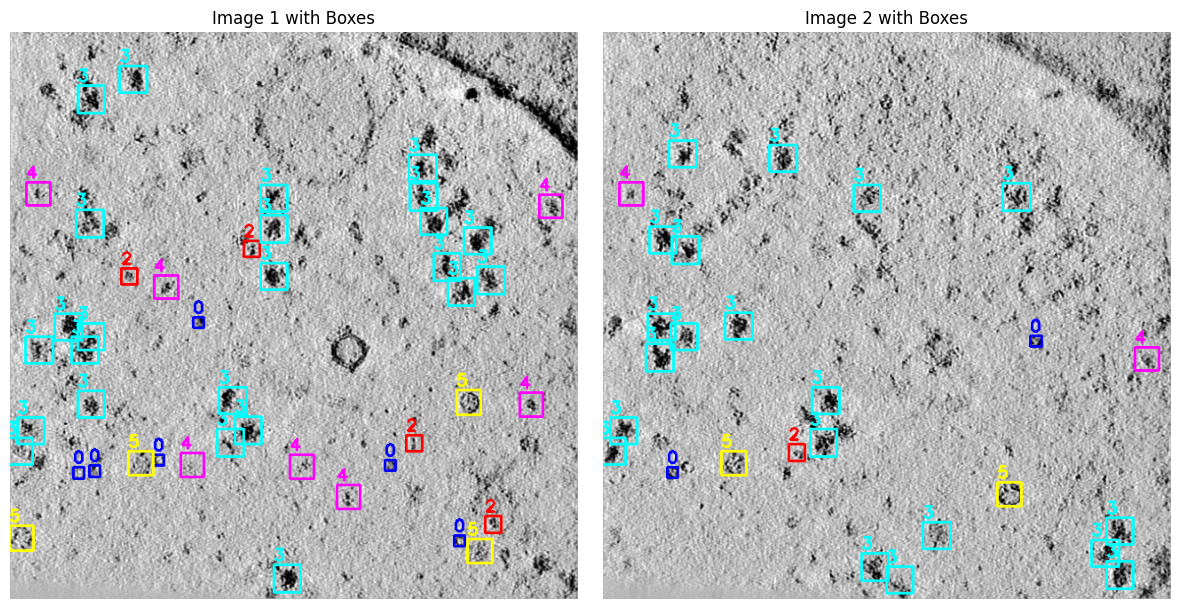

In [6]:
import cv2
import matplotlib.pyplot as plt

# ===== カラー設定 =====
# クラスIDをキーにして BGRカラーを指定する辞書
CLASS_COLORS = {
    0: (255, 0, 0),   # Blue
    1: (0, 255, 0),   # Green
    2: (0, 0, 255),   # Red
    3: (255, 255, 0), # Cyan
    4: (255, 0, 255), # Magenta
    5: (0, 255, 255), # Yellow
    6: (0, 128, 255), # Orange
    # 必要に応じて拡張
}

def get_color_for_class(class_id):
    """
    クラスIDに応じた色を返す。
    未定義のクラスIDの場合は白色を返す。
    """
    return CLASS_COLORS.get(class_id, (255, 255, 255))

# ===== YOLOのtxtファイルを読み込む関数 =====
def load_yolo_labels(txt_path):
    # 例: [[class, x_center, y_center, width, height], ...]
    labels = []
    with open(txt_path, 'r') as f:
        for line in f:
            c, x, y, w, h = line.strip().split()
            labels.append([int(c), float(x), float(y), float(w), float(h)])
    return labels

def annotate_image(img_path, txt_path):
    """
    画像とラベルを読み込み、クラスIDに応じた色でバウンディングボックスを描画した画像を返す。
    """
    img = cv2.imread(img_path)
    height, width, _ = img.shape
    labels = load_yolo_labels(txt_path)

    for label in labels:
        c, x, y, w, h = label

        # YOLO形式 → ピクセル座標へ変換
        x1 = int((x - w/2) * width)
        y1 = int((y - h/2) * height)
        x2 = int((x + w/2) * width)
        y2 = int((y + h/2) * height)

        # クラスIDに応じた色を取得
        color = get_color_for_class(c)

        # バウンディングボックス描画
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

        # クラスIDを文字として表示
        cv2.putText(img, str(c), (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return img

def show_images_side_by_side(img1, img2, title1="Image1", title2="Image2", figsize=(12, 6)):
    """
    2枚の画像を並べて表示する。
    figsizeで図のサイズを指定（単位はインチ）。
    """
    plt.figure(figsize=figsize)

    # 1枚目
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.title(title1)
    plt.axis('off')

    # 2枚目
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.title(title2)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# ===== 実際の使い方（例） =====
# 1枚目の画像とラベル
img_path_1 = f'{PROC}/datasets/czii_det2d/images/train/TS_6_4_1000.png'
txt_path_1 = f"{PROC}/datasets/czii_det2d/labels/train/TS_6_4_1000.txt"
annotated_img1 = annotate_image(img_path_1, txt_path_1)

# 2枚目の画像とラベル（例として別ファイルを指定）
img_path_2 = f'{PROC}/datasets/czii_det2d/images/train/TS_6_4_1200.png'
txt_path_2 = f"{PROC}/datasets/czii_det2d/labels/train/TS_6_4_1200.txt"
annotated_img2 = annotate_image(img_path_2, txt_path_2)

# 2枚のアノテーション済み画像を並べて表示（サイズを大きめに設定）
show_images_side_by_side(
    annotated_img1, annotated_img2,
    title1="Image 1 with Boxes",
    title2="Image 2 with Boxes",
    figsize=(12, 6)
)

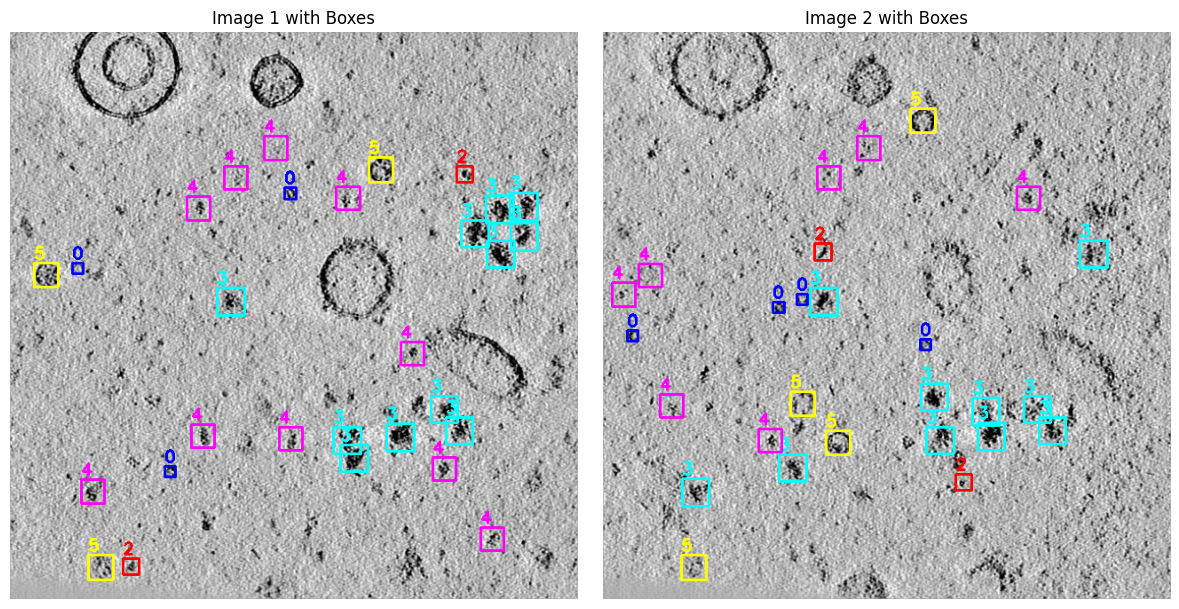

In [7]:
import cv2
import matplotlib.pyplot as plt

# ===== カラー設定 =====
# クラスIDをキーにして BGRカラーを指定する辞書
CLASS_COLORS = {
    0: (255, 0, 0),   # Blue
    1: (0, 255, 0),   # Green
    2: (0, 0, 255),   # Red
    3: (255, 255, 0), # Cyan
    4: (255, 0, 255), # Magenta
    5: (0, 255, 255), # Yellow
    6: (0, 128, 255), # Orange
    # 必要に応じて拡張
}

def get_color_for_class(class_id):
    """
    クラスIDに応じた色を返す。
    未定義のクラスIDの場合は白色を返す。
    """
    return CLASS_COLORS.get(class_id, (255, 255, 255))

# ===== YOLOのtxtファイルを読み込む関数 =====
def load_yolo_labels(txt_path):
    # 例: [[class, x_center, y_center, width, height], ...]
    labels = []
    with open(txt_path, 'r') as f:
        for line in f:
            c, x, y, w, h = line.strip().split()
            labels.append([int(c), float(x), float(y), float(w), float(h)])
    return labels

def annotate_image(img_path, txt_path):
    """
    画像とラベルを読み込み、クラスIDに応じた色でバウンディングボックスを描画した画像を返す。
    """
    img = cv2.imread(img_path)
    height, width, _ = img.shape
    labels = load_yolo_labels(txt_path)

    for label in labels:
        c, x, y, w, h = label

        # YOLO形式 → ピクセル座標へ変換
        x1 = int((x - w/2) * width)
        y1 = int((y - h/2) * height)
        x2 = int((x + w/2) * width)
        y2 = int((y + h/2) * height)

        # クラスIDに応じた色を取得
        color = get_color_for_class(c)

        # バウンディングボックス描画
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

        # クラスIDを文字として表示
        cv2.putText(img, str(c), (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return img

def show_images_side_by_side(img1, img2, title1="Image1", title2="Image2", figsize=(12, 6)):
    """
    2枚の画像を並べて表示する。
    figsizeで図のサイズを指定（単位はインチ）。
    """
    plt.figure(figsize=figsize)

    # 1枚目
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.title(title1)
    plt.axis('off')

    # 2枚目
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.title(title2)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# ===== 実際の使い方（例） =====
# 1枚目の画像とラベル
img_path_1 = f'{PROC}/datasets/czii_det2d/images/train/TS_6_6_1000.png'
txt_path_1 = f"{PROC}/datasets/czii_det2d/labels/train/TS_6_6_1000.txt"
annotated_img1 = annotate_image(img_path_1, txt_path_1)

# 2枚目の画像とラベル（例として別ファイルを指定）
img_path_2 = f'{PROC}/datasets/czii_det2d/images/train/TS_6_6_1200.png'
txt_path_2 = f"{PROC}/datasets/czii_det2d/labels/train/TS_6_6_1200.txt"
annotated_img2 = annotate_image(img_path_2, txt_path_2)

# 2枚のアノテーション済み画像を並べて表示（サイズを大きめに設定）
show_images_side_by_side(
    annotated_img1, annotated_img2,
    title1="Image 1 with Boxes",
    title2="Image 2 with Boxes",
    figsize=(12, 6)
)

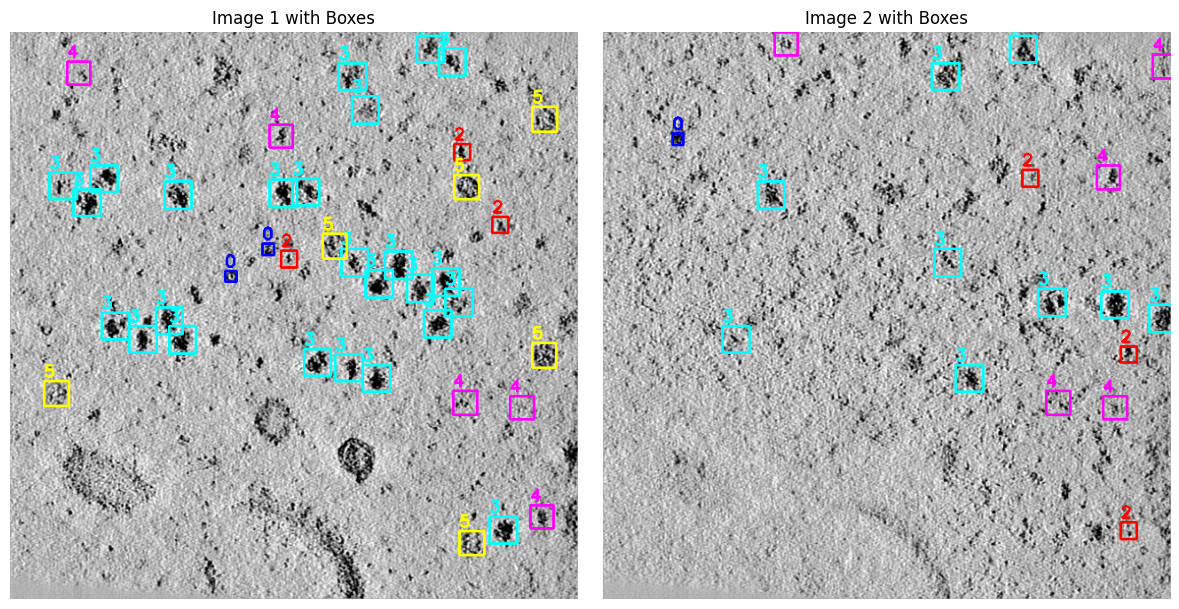

In [8]:
import cv2
import matplotlib.pyplot as plt

# ===== カラー設定 =====
# クラスIDをキーにして BGRカラーを指定する辞書
CLASS_COLORS = {
    0: (255, 0, 0),   # Blue
    1: (0, 255, 0),   # Green
    2: (0, 0, 255),   # Red
    3: (255, 255, 0), # Cyan
    4: (255, 0, 255), # Magenta
    5: (0, 255, 255), # Yellow
    6: (0, 128, 255), # Orange
    # 必要に応じて拡張
}

def get_color_for_class(class_id):
    """
    クラスIDに応じた色を返す。
    未定義のクラスIDの場合は白色を返す。
    """
    return CLASS_COLORS.get(class_id, (255, 255, 255))

# ===== YOLOのtxtファイルを読み込む関数 =====
def load_yolo_labels(txt_path):
    # 例: [[class, x_center, y_center, width, height], ...]
    labels = []
    with open(txt_path, 'r') as f:
        for line in f:
            c, x, y, w, h = line.strip().split()
            labels.append([int(c), float(x), float(y), float(w), float(h)])
    return labels

def annotate_image(img_path, txt_path):
    """
    画像とラベルを読み込み、クラスIDに応じた色でバウンディングボックスを描画した画像を返す。
    """
    img = cv2.imread(img_path)
    height, width, _ = img.shape
    labels = load_yolo_labels(txt_path)

    for label in labels:
        c, x, y, w, h = label

        # YOLO形式 → ピクセル座標へ変換
        x1 = int((x - w/2) * width)
        y1 = int((y - h/2) * height)
        x2 = int((x + w/2) * width)
        y2 = int((y + h/2) * height)

        # クラスIDに応じた色を取得
        color = get_color_for_class(c)

        # バウンディングボックス描画
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

        # クラスIDを文字として表示
        cv2.putText(img, str(c), (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return img

def show_images_side_by_side(img1, img2, title1="Image1", title2="Image2", figsize=(12, 6)):
    """
    2枚の画像を並べて表示する。
    figsizeで図のサイズを指定（単位はインチ）。
    """
    plt.figure(figsize=figsize)

    # 1枚目
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.title(title1)
    plt.axis('off')

    # 2枚目
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.title(title2)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# ===== 実際の使い方（例） =====
# 1枚目の画像とラベル
img_path_1 = f'{PROC}/datasets/czii_det2d/images/train/TS_69_2_1000.png'
txt_path_1 = f"{PROC}/datasets/czii_det2d/labels/train/TS_69_2_1000.txt"
annotated_img1 = annotate_image(img_path_1, txt_path_1)

# 2枚目の画像とラベル（例として別ファイルを指定）
img_path_2 = f'{PROC}/datasets/czii_det2d/images/train/TS_69_2_1200.png'
txt_path_2 = f"{PROC}/datasets/czii_det2d/labels/train/TS_69_2_1200.txt"
annotated_img2 = annotate_image(img_path_2, txt_path_2)

# 2枚のアノテーション済み画像を並べて表示（サイズを大きめに設定）
show_images_side_by_side(
    annotated_img1, annotated_img2,
    title1="Image 1 with Boxes",
    title2="Image 2 with Boxes",
    figsize=(12, 6)
)